##### Social Media Analytics
### Introduction to Text Mining
## Topic Modeling

### Initial setup

In [87]:
# Import packages
import csv
import re

import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import spacy
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# For pyLDAvis new version - replace the previous line
# import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()

In [88]:
# Just because of versions on my computer
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [89]:
# Load dataset
ds = pd.read_parquet("DailyMail.parquet.snappy", engine="fastparquet")

In [90]:
ds.head()

,Unnamed: 0,title,author,date,text,link,comments
0,0,Wave of looting ravages Russian border area am...,"Will Stewart, Christian Oliver",03/06/23,A wave of looting has reportedly hit a border ...,https://www.dailymail.co.uk/news/article-12155...,[Russians don't appear to understand that peop...
1,1,EXCLUSIVE: 'This is the beginning of the end o...,Chris Pleasance,03/06/23,"In the dawn hours of May 3, Moscovites awoke t...",https://www.dailymail.co.uk/news/article-12152...,[Putin: How does it feel when your country is ...
2,2,Naked protest at St Peter's Basilica: Man stri...,Christian Oliver,02/06/23,Visitors to St. Peter's Basilica got an unexpe...,https://www.dailymail.co.uk/news/article-12151...,"[Joe Biden needs to put some clothes on., He c..."
3,3,Russia accuses Apple of 'close cooperation' wi...,"Keith Griffith For Dailymail.com, Reuters",01/06/23,Russian security services have accused Apple o...,https://www.dailymail.co.uk/news/article-12150...,[Russia has turned into a criminal gang/mafia ...
4,4,Foster mother who 'rescued' orphans from Ukrai...,Ed Wight,01/06/23,A foster mum who rescued orphans from war-torn...,https://www.dailymail.co.uk/news/article-12148...,[I cannot believe what I have just read! I fe...


### Functions

In [91]:
# ds.text = ds.text.replace({" said ":'' , " u ":'', "'s ":''}, regex = True)

In [92]:
# Text preprocessing
def textPreProcess(
    rawText,
    removeHTML=True,
    charsToRemove=r"\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-|\'s|\'|\]|\[",
    removeNumbers=True,
    removeLineBreaks=False,
    specialCharsToRemove=r"[^\x00-\xfd]",
    convertToLower=True,
    removeConsecutiveSpaces=True,
):
    if type(rawText) != str:
        return rawText
    procText = rawText

    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText, "html.parser").get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove) > 0:
        procText = re.sub(charsToRemove, " ", procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r"\d+", " ", procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace("\n", " ").replace("\r", "")

    # Remove special characters
    if len(specialCharsToRemove) > 0:
        procText = re.sub(specialCharsToRemove, " ", procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower()

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(" +", " ", procText)

    return procText

In [93]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ""):
        return np.nan
    else:
        return word_tokenize(words)

In [94]:
# Function to create text from words
def recreateText(words):
    if type(words) == list:
        temp_str = (" ").join(words)
        return temp_str
    else:
        return np.nan

In [95]:
# Function to remove stop words
def removeStopWords(t, stop_words):
    if type(t) == list:
        return [w for w in t if not w in stop_words]
    else:
        return np.nan

In [96]:
# Function to lemmatize words
def lemmatize(words):
    if type(words) == list:
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(x) for x in words]
    else:
        return np.nan

### Analysis

In [97]:
# Create a dataframe with only the description
processedReviews = pd.DataFrame(
    data=ds.text.apply(textPreProcess).values,
    index=ds.index,
    columns=["PreProcessedText"],
)

In [98]:
# Tokekinze words
processedReviews["Words"] = processedReviews["PreProcessedText"].apply(tokenize_words)

# Remove stopwords
stop_words = set(stopwords.words("english"))
stop_words.update(
    [
        "said",
        "vladimir",
        "volodymyr",
        "joe",
        "dmitry",
        "sergei",
        "rishi",
        "ben",
        "antony",
        "olaf",
        "dmytro",
        "maria",
        "james",
        "ursula",
        "emmanuel",
        "john",
        "mykhailo",
        "jens",
        "oleh",
        "alexei",
        "fumio",
        "also",
        "valery",
        "year",
    ]
)
processedReviews["WordsCleaned"] = processedReviews["Words"].apply(
    removeStopWords, stop_words=stop_words
)

# Remove all reviews with no words
processedReviews = processedReviews[processedReviews["WordsCleaned"].str.len() > 0]

# Lemmative words
processedReviews["WordsLemmatized"] = processedReviews["WordsCleaned"].apply(lemmatize)

In [99]:
# Create dictionary (needed for LDA)
id2word = corpora.Dictionary(processedReviews["WordsLemmatized"])

In [100]:
# Create corpus
corpus = processedReviews["WordsLemmatized"]

In [101]:
# Create TDM (Frequency)
tdm = [id2word.doc2bow(text) for text in corpus]

In [102]:
# Build LDA model (can take from 2 to 10 minutes depending on the computer)
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=tdm,
    id2word=id2word,
    num_topics=6,
    random_state=123,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

In [103]:
# Print the keywords in the 10 topics
print(lda_model.print_topics(0))
doc_lda = lda_model[tdm]
# Interpretation: Topic 0 is represented as 0.055"walking" + 0.054"garden" + ...

# Visualize the topics (can take some mintues to run)
vis = pyLDAvis.gensim.prepare(lda_model, tdm, id2word)
pyLDAvis.display(vis)

# If it is a newwer version of puLDavis, use this instead of the previous
# vis = gensimvis.prepare(lda_model, tdm, id2word)
# pyLDAvis.display(vis)

# pyLDAvis.enable_notebook() # Remove remarks to see in notebook instead of the browser

[(4, '0.020*"energy" + 0.020*"price" + 0.014*"per" + 0.013*"£" + 0.012*"cent" + 0.012*"gas" + 0.009*"government" + 0.008*"oil" + 0.008*"cost" + 0.008*"$"'), (5, '0.028*"putin" + 0.019*"russian" + 0.013*"war" + 0.010*"russia" + 0.007*"kremlin" + 0.005*"death" + 0.005*"moscow" + 0.004*"one" + 0.004*"ukraine" + 0.004*"former"'), (3, '0.014*"u" + 0.007*"biden" + 0.007*"russian" + 0.006*"security" + 0.005*"sea" + 0.005*"american" + 0.005*"white" + 0.005*"intelligence" + 0.005*"state" + 0.004*"house"'), (1, '0.024*"russian" + 0.021*"ukraine" + 0.018*"ukrainian" + 0.014*"russia" + 0.012*"force" + 0.011*"attack" + 0.011*"city" + 0.009*"region" + 0.009*"military" + 0.008*"kyiv"'), (0, '0.009*"ukraine" + 0.008*"people" + 0.007*"war" + 0.007*"one" + 0.005*"country" + 0.005*"world" + 0.004*"family" + 0.004*"time" + 0.004*"ukrainian" + 0.004*"would"'), (2, '0.023*"ukraine" + 0.020*"russia" + 0.012*"putin" + 0.011*"war" + 0.009*"would" + 0.009*"u" + 0.008*"russian" + 0.008*"country" + 0.008*"nuclear

/home/tosk/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


### Evaluation of topic models
Good description at: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [104]:
# Compute Perplexity
print(
    "\nPerplexity: ", lda_model.log_perplexity(tdm)
)  # lower value is better (some liteture do not recommend the use of this measure)


Perplexity:  -8.111875632852183


In [105]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=corpus, dictionary=id2word, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.45426372375011


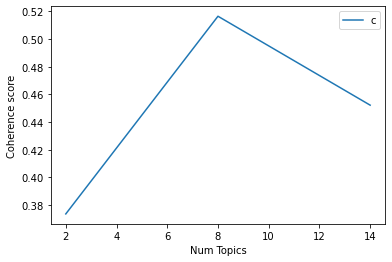

In [106]:
# HOW TO SELECT K (based on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=123,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha="auto",
            per_word_topics=True,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# ATTENTION!!!! Can take a LONG time to run.
lowerBound = 2
upperBound = 20
step = 6
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=tdm,
    texts=corpus,
    start=lowerBound,
    limit=upperBound,
    step=step,
)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()
# The coherence score is decreasing. A higher value should be chosen, because as K increases the probability of having repeated keywords increases.
# ...So, in this case we may choose 8, as there is an inflaction at K=8